In [1]:
import pandas as pd
import numpy as np
import math
from pandas_datareader.data import DataReader
import pandas_datareader
from datetime import datetime as dt
import os
import matplotlib.pyplot as plt
from datetime import timedelta
import time
from pandas_datareader.moex import MoexReader
import datetime
from scipy.optimize import fsolve
from scipy.optimize import fmin, fmin_powell, basinhopping, differential_evolution, minimize
import warnings
from scipy.stats import t

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

/Users/denisbondarenko/miniconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [7]:
trades_info = pd.read_excel('trades_info.xlsx', index_col=0)
trades_info.head(2)

,isin,mean_volume,sum_volume,mean_ntrades,sum_ntrades,days_trades,days_on_the_market,rating,%_of_days_traded
0,RU000A101PG7,979.173594,400482,4.777506,1954,336,420,AAA,0.800000
1,RU000A101PF9,2009.009780,821685,1.449878,593,197,420,AAA,0.469048


In [8]:
lb_info = trades_info[(trades_info['%_of_days_traded'] > .9)].copy() # liquid bonds info - those taken in analysis
# lb_info = pd.read_excel('liquid_bonds_info.xlsx')
issuers = pd.Series()
ratings = lb_info['rating'].unique()
for rating in ratings:
    issuers = issuers.append(pd.read_excel(rating + '_bonds.xlsx')[['ISIN', 'Эмитент']].set_index('ISIN'))

del issuers[0]    
issuers.rename(columns = {'Эмитент':'Issuer'}, inplace = True)
lb_info = lb_info.merge(right = issuers, how = 'left', left_on = 'isin', right_index = True)
lb_info.head()
lb_info.head(2)

,isin,mean_volume,sum_volume,mean_ntrades,sum_ntrades,days_trades,days_on_the_market,rating,%_of_days_traded,Issuer
3,RU000A103AT8,6799.421053,904323,35.526316,4725,133,135,AAA,0.985185,Атомэнергопром
5,RU000A0JTM28,2090.611111,1053668,12.684524,6393,496,522,AAA,0.950192,Башнефть


In [9]:
# List of bonds with embedded put option
lb_info['Option'] = 0
lb_info.set_index('isin', inplace = True)
for isin in lb_info.index:
    q = pd.read_csv(os.getcwd() + '/Quotes/' + isin + '.csv')
    q.set_index('Trade date', inplace = True)
    q.sort_index(ascending = True, inplace = True)
    if q[pd.notna(q['Put/call date'])].shape[0] > 0: 
        lb_info['Option'][isin] = 1
lb_info.reset_index(inplace = True)
lb_info = lb_info[lb_info['Option'] == 0]
print(lb_info.shape)

(198, 11)


# G-curve - risk-free curve

In [11]:
pars = pd.read_csv('dynamic-2.csv', skiprows = 2, sep=';', decimal = ',')
#  Data from https://www.moex.com/s2532
pars['tradedate'] = pd.to_datetime(pars['tradedate'], format = '%d.%m.%Y')
pars.set_index('tradedate', inplace=True)
display(pars.head(2))

date = pars.index[0]
def gcurve(t):
    global pars, date, a, b, row, adj
    k = 1.6
    a1 = 0
    a2 = .6
    a3 = a2 + a2 * k ** 1
    a4 = a3 + a2 * k ** 2
    a5 = a4 + a2 * k ** 3
    a6 = a5 + a2 * k ** 4
    a7 = a6 + a2 * k ** 5
    a8 = a7 + a2 * k ** 6
    a9 = a8 + a2 * k ** 7
    a = np.zeros(9)
    a[1] = .6
    b = np.zeros(9)
    b[0] = a[1]
    b[1] = b[0] * k
    for i in range(1, 8):
        a[i + 1] = a[i] * k ** i
        b[i + 1] = b[i] * k
    b1 = a2
    b2 = b1 * k 
    b3 = b2 * k
    b4 = b3 * k
    b5 = b4 * k
    b6 = b5 * k
    b7 = b6 * k
    b8 = b7 * k
    b9 = b8 * k
    row = pars.loc[date]
    beta0 = row['B1']
    beta1 = row['B2']
    beta2 = row['B3']
    tau = row['T1']
    rate = beta0 + (beta1 + beta2) * (tau / t) * (1 - np.exp(-t/tau)) - \
        beta2 * np.exp(-t/tau) + row['G1'] * np.exp(-(t - a1) ** 2 / b1 ** 2) + \
        row['G2'] * np.exp(-(t - a2) ** 2 / b2 ** 2) + row['G3'] * np.exp(-(t - a3) ** 2 / b3 ** 2) + \
        row['G4'] * np.exp(-(t - a4) ** 2 / b4 ** 2) + row['G5'] * np.exp(-(t - a5) ** 2 / b5 ** 2) + \
        row['G6'] * np.exp(-(t - a6) ** 2 / b6 ** 2) + row['G7'] * np.exp(-(t - a7) ** 2 / b7 ** 2) + \
        row['G8'] * np.exp(-(t - a8) ** 2 / b8 ** 2) + row['G9'] * np.exp(-(t - a9) ** 2 / b9 ** 2)

    return rate / 10000
    

,tradetime,B1,B2,B3,T1,G1,G2,G3,G4,G5,G6,G7,G8,G9
tradedate,,,,,,,,,,,,,,
2014-01-06,12:21:16,877.951361,-311.324633,51.105265,4.836731,0.000000,0.000000,-0.235430,-0.602083,-0.725340,-0.341294,0.683989,0.0,0.0
2014-01-08,12:41:22,879.619947,-312.611788,51.560662,4.824178,-0.005661,-0.005661,-0.214698,-1.641290,-4.821431,0.328790,3.391207,0.0,0.0


In [12]:
date = dt.strptime('2020-01-06', '%Y-%m-%d')
check = np.array([.25, .5, .75, 1, 2, 3, 5, 7, 10, 15, 20, 30])
(np.exp(gcurve(check)) - 1) * 100

array([5.02533272, 5.13120315, 5.23143762, 5.32520507, 5.61677296,
       5.79540676, 6.06553994, 6.25577939, 6.42531266, 6.55148236,
       6.60648491, 6.65799445])

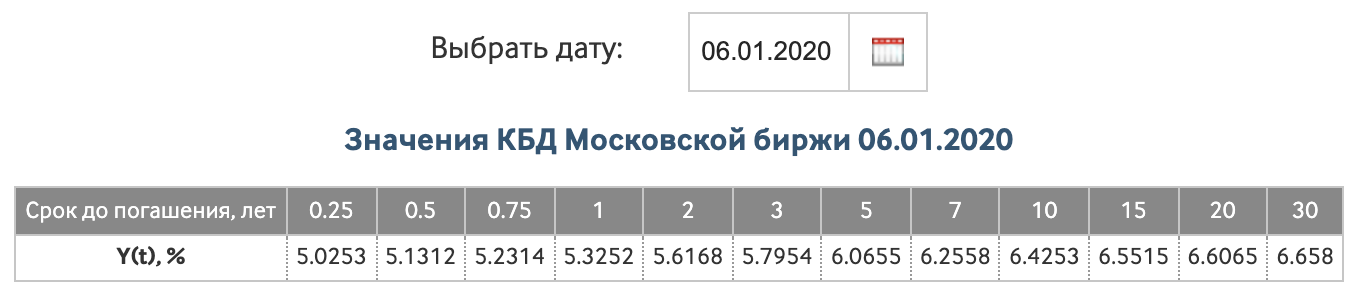

# Bonds payment info

In [13]:
files = os.listdir('Coupons')
files = sorted(files)[1:]
isins = [link[:-5] for link in files]

In [14]:
payments = pd.DataFrame()
dates = []
for file in files:
    coupons = pd.read_excel(os.getcwd()+'/Coupons/' + file, skiprows=2, index_col = 0)
    dates += coupons['Фактическая выплата'].to_list()
    if '2028-09-12' in coupons['Фактическая выплата']: print(file)
dates
print('2028-09-12' in dates)
payments['Date'] = dates
print('2028-09-12' in payments['Date'])
print(payments.shape)
payments.drop_duplicates(inplace = True)
print('2028-09-12' in payments['Date'])
print(payments.shape)
payments.set_index('Date', inplace = True)
print('2028-09-12' in payments.index)
print(payments.shape)


for file in files:
    coupons = pd.read_excel(os.getcwd()+'/Coupons/' + file, skiprows=2, index_col = 0)
    coupons.fillna(method = 'ffill', inplace=True)
    coupons.fillna(0, inplace=True)
    payments[file[:-5]] = 0
    for index, row in coupons.iterrows():
        if row['Фактическая выплата'] not in payments.index: print(row['Фактическая выплата'])
        try: payments[file[:-5]][row['Фактическая выплата']] = row['Сумма купона RUB'] + row['Погашение RUB']
        except: payments[file[:-5]][row['Фактическая выплата']] = row['Погашение RUB']
    
        
    
    
    
#     display(coupons.head(1))
payments.to_csv(os.getcwd()+ '/Inputs_for_modelling/payments.csv')
payments  

False
False
(7024, 1)
False
(3042, 1)
True
(3042, 0)


,RU000A0JQ7Z2,RU000A0JQRD9,RU000A0JT6B2,RU000A0JT940,RU000A0JT965,RU000A0JTM28,RU000A0JTM36,RU000A0JTM44,RU000A0JTMK9,RU000A0JTS06,RU000A0JTS22,RU000A0JTTA5,RU000A0JTU85,RU000A0JTVJ2,RU000A0JU773,RU000A0JUA45,RU000A0JUV08,RU000A0JVA10,RU000A0JVD25,RU000A0JVUK8,RU000A0JVVA7,RU000A0JVWD9,RU000A0JVWJ6,RU000A0JW1G7,RU000A0JW1P8,RU000A0JWCM0,RU000A0JWDN6,RU000A0JWG05,RU000A0JWN63,RU000A0JWN89,RU000A0JWP46,RU000A0JWST1,RU000A0JWVL2,RU000A0JWYQ5,RU000A0JWZY6,RU000A0JX355,RU000A0JX4Q9,RU000A0JX5W4,RU000A0JXC24,RU000A0JXE06,RU000A0JXEV5,RU000A0JXFS8,RU000A0JXHE4,RU000A0JXLR8,RU000A0JXME4,RU000A0JXN05,RU000A0JXN21,RU000A0JXNF9,RU000A0JXP45,RU000A0JXPD9,RU000A0JXPG2,RU000A0JXPN8,RU000A0JXQ28,RU000A0JXQ44,RU000A0JXQ85,RU000A0JXQK2,RU000A0JXRD5,RU000A0JXRV7,RU000A0JXVG0,RU000A0JXVM8,RU000A0JXY44,RU000A0JXZB2,RU000A0ZYBM4,RU000A0ZYC98,RU000A0ZYDD9,RU000A0ZYDH0,RU000A0ZYDS7,RU000A0ZYEB1,RU000A0ZYEE5,RU000A0ZYFC6,RU000A0ZYG52,RU000A0ZYJ91,RU000A0ZYJR6,RU000A0ZYLC4,RU000A0ZYLF7,RU000A0ZYQY7,RU000A0ZYRX7,RU000A0ZYRY5,RU000A0ZYT40,RU000A0ZYU05,RU000A0ZYU21,RU000A0ZYU39,RU000A0ZYUS1,RU000A0ZYUY9,RU000A0ZYVU5,RU000A0ZYWU3,RU000A0ZYWY5,RU000A0ZYX69,RU000A0ZYXJ4,RU000A0ZYXV9,RU000A0ZYYE3,RU000A0ZZ083,RU000A0ZZ117,RU000A0ZZ1H2,RU000A0ZZ1J8,RU000A0ZZ5J9,RU000A0ZZ9R4,RU000A0ZZ9W4,RU000A0ZZBN9,RU000A0ZZBV2,RU000A0ZZE20,RU000A0ZZES2,RU000A0ZZET0,RU000A0ZZPZ3,RU000A0ZZQN7,RU000A0ZZV11,RU000A0ZZWZ9,RU000A0ZZX19,RU000A0ZZXM5,RU000A0ZZZ17,RU000A0ZZZ66,RU000A0ZZZP3,RU000A100220,RU000A100238,RU000A1002C2,RU000A1002E8,RU000A1002P4,RU000A1002U4,RU000A1003A4,RU000A1003E6,RU000A1003L1,RU000A1003Q0,RU000A100436,RU000A1004K1,RU000A1005L6,RU000A1005N2,RU000A100733,RU000A100782,RU000A1008B1,RU000A1008D7,RU000A1008J4,RU000A1008W7,RU000A1008Z0,RU000A1009B9,RU000A1009Z8,RU000A100A33,RU000A100A58,RU000A100A66,RU000A100A90,RU000A100AB2,RU000A100AF3,RU000A100BB0,RU000A100BM7,RU000A100DZ5,RU000A100E88,RU000A100EX8,RU000A100FE5,RU000A100G03,RU000A100GY1,RU000A100HE1,RU000A100HH4,RU000A100HU7,RU000A100K80,RU000A100KL0,RU000A100L14,RU000A100LL8,RU000A100LS3,RU000A100MG6,RU000A100N12,RU000A100NS9,RU000A100PB0,RU000A100PE4,RU000A100PQ8,RU000A100Q35,RU000A100Q50,RU000A100RG5,RU000A100RQ4,RU000A100TD8,RU000A100TF3,RU000A100UG9,RU000A100V38,RU000A100V79,RU000A100VQ6,RU000A100VR4,RU000A100VS2,RU000A100VY0,RU000A100W60,RU000A100WC4,RU000A100X77,RU000A100XC2,RU000A100XU4,RU000A100YG1,RU000A100YQ0,RU000A100YR8,RU000A100YT4,RU000A100YU2,RU000A100YW8,RU000A100Z00,RU000A100ZK0,RU000A100ZS3,RU000A101012,RU000A1010B7,RU000A1010M4,RU000A101129,RU000A1011C3,RU000A1011R1,RU000A1012K4,RU000A1013P1,RU000A1013Y3,RU000A1014A1,RU000A101541,RU000A1015A8,RU000A101624,RU000A1016U4,RU000A1017J5,RU000A1018C8,RU000A1018D6,RU000A1018K1,RU000A1018X4,RU000A101939,RU000A101C89,RU000A101CL5,RU000A101D13,RU000A101DD0,RU000A101DU4,RU000A101FC7,RU000A101FG8,RU000A101FH6,RU000A101GJ0,RU000A101GR3,RU000A101GZ6,RU000A101H43,RU000A101HA7,RU000A101HJ8,RU000A101KK0,RU000A101LJ0,RU000A101LQ5,RU000A101LY9,RU000A101M04,RU000A101MB5,RU000A101MC3,RU000A101MT7,RU000A101NG2,RU000A101PG7,RU000A101PJ1,RU000A101PP8,RU000A101PU8,RU000A101Q26,RU000A101QC4,RU000A101QL5,RU000A101QM3,RU000A101QN1,RU000A101QW2,RU000A101R33,RU000A101RD0,RU000A101S81,RU000A101S99,RU000A101SC0,RU000A101SD8,RU000A101SF3,RU000A101SM9,RU000A101ST4,RU000A101TB0,RU000A101TE4,RU000A101U38,RU000A101UQ6,RU000A101WB4,RU000A101WF5,RU000A101WQ2,RU000A101XD8,RU000A101XN7,RU000A101YD6,RU000A101Z74,RU000A102028,RU000A102101,RU000A1021G3,RU000A102200,RU000A1023K1,RU000A1024W4,RU000A102556,RU000A102580,RU000A1025E9,RU000A1025U5,RU000A1026C1,RU000A102713,RU000A102788,RU000A102960,RU000A1029P7,RU000A102A07,RU000A102B30,RU000A102B48,RU000A102B97,RU000A102BK7,RU000A102CU4,RU000A102DB2,RU000A102DZ1,RU000A102F85,RU000A102FC5,RU000A102FR3,RU000A102FS1,RU000A102FT9,RU000A102HB3,RU000A102HG2,RU000A102JZ8,RU000A102K39,RU000A102LB5,RU000A102LD1,RU000A102LF6,RU000A102LS9,RU000A102M45,RU000A102QP4,RU000A102QX8,RU000A102R73,RU000A102RF3,RU000A102RL1,RU000A102RN7,RU000A102RQ0,RU000A10

# Curves intitation

In [15]:
omega = [7, 3.5, -2.5, 2]
t = np.linspace(0, 30, 10000)
def ns(m, omega):
    tau = omega[0]
    beta0 = omega[1]
    beta1 = omega[2]
    beta2 = omega[3]
    return beta0 + (beta1 + beta2) * (1 - np.exp(- m / tau)) / (m / tau) - beta2 * np.exp(- m / tau)

In [16]:
start_date = '2020-01-01'
end_date = '2021-12-31'
isin = 'RU000A0JQRD9'
rd = MoexReader(isin, start_date, end_date)
df = rd.read()
prices = pd.DataFrame(columns = lb_info['isin'].values, index = df.index, dtype = 'object')
k = 0
for isin in prices.columns:
    k += 1 
#     print(isin)
    if prices.isna()[isin].sum() < 504: continue
    rd = MoexReader(isin, start_date, end_date)
    df = rd.read()
    prices[isin] = df.reset_index().sort_values(['TRADEDATE', 'NUMTRADES'],
                                ascending = False).drop_duplicates('TRADEDATE',
                            keep = 'first').set_index('TRADEDATE')['LEGALCLOSEPRICE']
    if k % 25 == 0: 
        print(k)
        print(prices.shape)
    time.sleep(1)
print(prices.shape)
prices.head()

25
(504, 198)
50
(504, 198)
75
(504, 198)
100
(504, 198)
125
(504, 198)
150
(504, 198)
175
(504, 198)
(504, 198)


,RU000A103AT8,RU000A0JTM28,RU000A1039K7,RU000A103GF4,RU000A103Q81,RU000A103BE8,RU000A103YS0,RU000A1046G0,RU000A0ZZZP3,RU000A100BM7,RU000A100GY1,RU000A1013P1,RU000A101TB0,RU000A101WF5,RU000A102FC5,RU000A1031U3,RU000A100VQ6,RU000A100EX8,RU000A100LL8,RU000A101QM3,RU000A101QN1,RU000A0JXNF9,RU000A0ZYDS7,RU000A0ZYLC4,RU000A0ZYXV9,RU000A1017J5,RU000A101GJ0,RU000A104123,RU000A0JXEV5,RU000A0ZYFC6,RU000A0ZYWY5,RU000A100238,RU000A100A58,RU000A100A66,RU000A100HU7,RU000A100ZK0,RU000A101939,RU000A101FH6,RU000A101NG2,RU000A101RD0,RU000A102VL3,RU000A0ZZX19,RU000A1002C2,RU000A1008D7,RU000A1010M4,RU000A101M04,RU000A102QP4,RU000A0JQRD9,RU000A103NY1,RU000A100220,RU000A0JT940,RU000A0JT965,RU000A0JTS06,RU000A0ZZ117,RU000A0ZZBN9,RU000A0ZZE20,RU000A0ZZWZ9,RU000A100K80,RU000A101C89,RU000A101QW2,RU000A102YG7,RU000A1025U5,RU000A102FR3,RU000A102CU4,RU000A102RQ0,RU000A102RS6,RU000A103661,RU000A103G42,RU000A103G75,RU000A103KG4,RU000A103YM3,RU000A1018K1,RU000A0ZYDD9,RU000A0ZYUS1,RU000A1010B7,RU000A1003L1,RU000A0ZZZ66,RU000A100PQ8,RU000A102788,RU000A102A07,RU000A102JZ8,RU000A102S80,RU000A1030D1,RU000A1036E6,RU000A103RS4,RU000A103943,RU000A103PT6,RU000A100G03,RU000A0ZZXM5,RU000A1002E8,RU000A100VR4,RU000A1008Z0,RU000A100LS3,RU000A100RG5,RU000A101LJ0,RU000A101R33,RU000A101MC3,RU000A1036H9,RU000A101HJ8,RU000A101PJ1,RU000A1002U4,RU000A1018X4,RU000A0ZYC98,RU000A103PE8,RU000A101U38,RU000A1038F9,RU000A0JW1G7,RU000A100YR8,RU000A102HB3,RU000A101DD0,RU000A1036F3,RU000A102RL1,RU000A101WQ2,RU000A102713,RU000A0ZYXJ4,RU000A0ZZPZ3,RU000A101FG8,RU000A101FC7,RU000A101LY9,RU000A103EZ7,RU000A103NZ8,RU000A1038D4,RU000A100YU2,RU000A102Y58,RU000A1013Y3,RU000A1024W4,RU000A100YG1,RU000A101H43,RU000A102RX6,RU000A103L03,RU000A0JXVG0,RU000A101SM9,RU000A103DP0,RU000A1043N3,RU000A1034T9,RU000A100WC4,RU000A1026C1,RU000A103C46,RU000A0JXY44,RU000A102LB5,RU000A103G91,RU000A100NS9,RU000A100PE4,RU000A100XU4,RU000A103F68,RU000A102TT0,RU000A101D13,RU000A102SG9,RU000A1035D0,RU000A103G00,RU000A100MG6,RU000A1030X9,RU000A103WQ8,RU000A101LQ5,RU000A102SC8,RU000A0ZZ9W4,RU000A101GZ6,RU000A103760,RU000A103F27,RU000A0JXHE4,RU000A0JXME4,RU000A101WB4,RU000A102F85,RU000A103RT2,RU000A102B48,RU000A1016U4,RU000A102DZ1,RU000A102LS9,RU000A102X18,RU000A103WX4,RU000A100X77,RU000A102QX8,RU000A103WZ9,RU000A1012K4,RU000A102556,RU000A103WR6,RU000A1029P7,RU000A1030K6,RU000A100Z00,RU000A102M45,RU000A100V38,RU000A101HA7,RU000A102HG2,RU000A1040V2,RU000A101TE4,RU000A101624,RU000A1014A1,RU000A102101,RU000A102ZS9,RU000A100RQ4,RU000A101QC4,RU000A1030U5,RU000A1003E6,RU000A103455,RU000A102580,RU000A1032S5,RU000A1025E9,RU000A1018D6
TRADEDATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-06,NaN,104.19,NaN,NaN,NaN,NaN,NaN,NaN,106.49,105.00,105.25,102.91,NaN,NaN,NaN,NaN,102.49,103.65,106.13,NaN,NaN,105.90,105.00,106.2,102.99,103.24,NaN,NaN,109.29,104.46,102.49,107.70,107.10,109.01,104.50,101.20,100.50,NaN,NaN,NaN,NaN,106.5,109.95,116.00,101.00,NaN,NaN,106.09,NaN,109.68,104.40,105.22,102.00,103.57,103.49,104.40,104.85,103.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,103.50,106.00,103.05,100.29,105.50,107.29,103.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,105.69,107.89,107.73,103.70,105.40,103.50,103.54,NaN,NaN,NaN,NaN,NaN,NaN,104.50,100.89,105.00,NaN,NaN,NaN,116.00,102.24,NaN,NaN,NaN,NaN,NaN,NaN,102.40,106.13,NaN,NaN,NaN,NaN,NaN,NaN,101.90,NaN,101.90,NaN,104.95,NaN,NaN,NaN,104.98,NaN,NaN,NaN,NaN,102.25,NaN,NaN,107.90,NaN,NaN,NaN,104.75,103.79,NaN,NaN,NaN,NaN,NaN,NaN,108.84,NaN,NaN,NaN,NaN,102.67,NaN,NaN,NaN,107.69,109.65,NaN,NaN,NaN,NaN,99.96,NaN,NaN,NaN,NaN,101.99,NaN,NaN,104.69,NaN,NaN,NaN,NaN,100.08,NaN,107.0,NaN,NaN,NaN,NaN,106.00,101.15,NaN,NaN,102.96,NaN,NaN,104.78,NaN,NaN,NaN,NaN,100.49
2020-01-08,NaN,104.16,NaN,NaN,NaN,NaN,NaN,NaN,105.54,105.95,104.52,102.26,NaN,NaN,NaN,NaN,102.49,106.30,106.13,NaN,NaN,105.41,105.19,106.2,105.00,102.70,NaN,NaN,104.82,104.40,102.51

# Flag of state affiliation

In [18]:
state_flags = pd.read_excel('Flags_info.xlsx', index_col = 0)
# del state_flags['Unnamed: 0']
state_flags['Flag'] = state_flags['Flag'].fillna(0)
state_flags['Flag+'] = state_flags['Flag+'].fillna(0)
state_flags['Flag-'] = state_flags['Flag-'].fillna(0)
state_flags.to_excel(os.getcwd() + '/Inputs_for_modelling/state_flags.xlsx')
state_flags.head(2)

,Name,Flag,Flag+,Flag-
ISIN,,,,
RU000A0JXVM8,"Россети, БО-001P-01 (RU000A0JXVM8)",1,0,0
RU000A1024W4,"Группа Черкизово, БО-001P-03 (RU000A1024W4)",0,1,0


# Bid-ask spread (liquidity risk premia)

In [19]:
quotes = pd.DataFrame(index = prices.index, columns = payments.columns, dtype = 'object')
quotes.head(3)

,RU000A0JQ7Z2,RU000A0JQRD9,RU000A0JT6B2,RU000A0JT940,RU000A0JT965,RU000A0JTM28,RU000A0JTM36,RU000A0JTM44,RU000A0JTMK9,RU000A0JTS06,RU000A0JTS22,RU000A0JTTA5,RU000A0JTU85,RU000A0JTVJ2,RU000A0JU773,RU000A0JUA45,RU000A0JUV08,RU000A0JVA10,RU000A0JVD25,RU000A0JVUK8,RU000A0JVVA7,RU000A0JVWD9,RU000A0JVWJ6,RU000A0JW1G7,RU000A0JW1P8,RU000A0JWCM0,RU000A0JWDN6,RU000A0JWG05,RU000A0JWN63,RU000A0JWN89,RU000A0JWP46,RU000A0JWST1,RU000A0JWVL2,RU000A0JWYQ5,RU000A0JWZY6,RU000A0JX355,RU000A0JX4Q9,RU000A0JX5W4,RU000A0JXC24,RU000A0JXE06,RU000A0JXEV5,RU000A0JXFS8,RU000A0JXHE4,RU000A0JXLR8,RU000A0JXME4,RU000A0JXN05,RU000A0JXN21,RU000A0JXNF9,RU000A0JXP45,RU000A0JXPD9,RU000A0JXPG2,RU000A0JXPN8,RU000A0JXQ28,RU000A0JXQ44,RU000A0JXQ85,RU000A0JXQK2,RU000A0JXRD5,RU000A0JXRV7,RU000A0JXVG0,RU000A0JXVM8,RU000A0JXY44,RU000A0JXZB2,RU000A0ZYBM4,RU000A0ZYC98,RU000A0ZYDD9,RU000A0ZYDH0,RU000A0ZYDS7,RU000A0ZYEB1,RU000A0ZYEE5,RU000A0ZYFC6,RU000A0ZYG52,RU000A0ZYJ91,RU000A0ZYJR6,RU000A0ZYLC4,RU000A0ZYLF7,RU000A0ZYQY7,RU000A0ZYRX7,RU000A0ZYRY5,RU000A0ZYT40,RU000A0ZYU05,RU000A0ZYU21,RU000A0ZYU39,RU000A0ZYUS1,RU000A0ZYUY9,RU000A0ZYVU5,RU000A0ZYWU3,RU000A0ZYWY5,RU000A0ZYX69,RU000A0ZYXJ4,RU000A0ZYXV9,RU000A0ZYYE3,RU000A0ZZ083,RU000A0ZZ117,RU000A0ZZ1H2,RU000A0ZZ1J8,RU000A0ZZ5J9,RU000A0ZZ9R4,RU000A0ZZ9W4,RU000A0ZZBN9,RU000A0ZZBV2,RU000A0ZZE20,RU000A0ZZES2,RU000A0ZZET0,RU000A0ZZPZ3,RU000A0ZZQN7,RU000A0ZZV11,RU000A0ZZWZ9,RU000A0ZZX19,RU000A0ZZXM5,RU000A0ZZZ17,RU000A0ZZZ66,RU000A0ZZZP3,RU000A100220,RU000A100238,RU000A1002C2,RU000A1002E8,RU000A1002P4,RU000A1002U4,RU000A1003A4,RU000A1003E6,RU000A1003L1,RU000A1003Q0,RU000A100436,RU000A1004K1,RU000A1005L6,RU000A1005N2,RU000A100733,RU000A100782,RU000A1008B1,RU000A1008D7,RU000A1008J4,RU000A1008W7,RU000A1008Z0,RU000A1009B9,RU000A1009Z8,RU000A100A33,RU000A100A58,RU000A100A66,RU000A100A90,RU000A100AB2,RU000A100AF3,RU000A100BB0,RU000A100BM7,RU000A100DZ5,RU000A100E88,RU000A100EX8,RU000A100FE5,RU000A100G03,RU000A100GY1,RU000A100HE1,RU000A100HH4,RU000A100HU7,RU000A100K80,RU000A100KL0,RU000A100L14,RU000A100LL8,RU000A100LS3,RU000A100MG6,RU000A100N12,RU000A100NS9,RU000A100PB0,RU000A100PE4,RU000A100PQ8,RU000A100Q35,RU000A100Q50,RU000A100RG5,RU000A100RQ4,RU000A100TD8,RU000A100TF3,RU000A100UG9,RU000A100V38,RU000A100V79,RU000A100VQ6,RU000A100VR4,RU000A100VS2,RU000A100VY0,RU000A100W60,RU000A100WC4,RU000A100X77,RU000A100XC2,RU000A100XU4,RU000A100YG1,RU000A100YQ0,RU000A100YR8,RU000A100YT4,RU000A100YU2,RU000A100YW8,RU000A100Z00,RU000A100ZK0,RU000A100ZS3,RU000A101012,RU000A1010B7,RU000A1010M4,RU000A101129,RU000A1011C3,RU000A1011R1,RU000A1012K4,RU000A1013P1,RU000A1013Y3,RU000A1014A1,RU000A101541,RU000A1015A8,RU000A101624,RU000A1016U4,RU000A1017J5,RU000A1018C8,RU000A1018D6,RU000A1018K1,RU000A1018X4,RU000A101939,RU000A101C89,RU000A101CL5,RU000A101D13,RU000A101DD0,RU000A101DU4,RU000A101FC7,RU000A101FG8,RU000A101FH6,RU000A101GJ0,RU000A101GR3,RU000A101GZ6,RU000A101H43,RU000A101HA7,RU000A101HJ8,RU000A101KK0,RU000A101LJ0,RU000A101LQ5,RU000A101LY9,RU000A101M04,RU000A101MB5,RU000A101MC3,RU000A101MT7,RU000A101NG2,RU000A101PG7,RU000A101PJ1,RU000A101PP8,RU000A101PU8,RU000A101Q26,RU000A101QC4,RU000A101QL5,RU000A101QM3,RU000A101QN1,RU000A101QW2,RU000A101R33,RU000A101RD0,RU000A101S81,RU000A101S99,RU000A101SC0,RU000A101SD8,RU000A101SF3,RU000A101SM9,RU000A101ST4,RU000A101TB0,RU000A101TE4,RU000A101U38,RU000A101UQ6,RU000A101WB4,RU000A101WF5,RU000A101WQ2,RU000A101XD8,RU000A101XN7,RU000A101YD6,RU000A101Z74,RU000A102028,RU000A102101,RU000A1021G3,RU000A102200,RU000A1023K1,RU000A1024W4,RU000A102556,RU000A102580,RU000A1025E9,RU000A1025U5,RU000A1026C1,RU000A102713,RU000A102788,RU000A102960,RU000A1029P7,RU000A102A07,RU000A102B30,RU000A102B48,RU000A102B97,RU000A102BK7,RU000A102CU4,RU000A102DB2,RU000A102DZ1,RU000A102F85,RU000A102FC5,RU000A102FR3,RU000A102FS1,RU000A102FT9,RU000A102HB3,RU000A102HG2,RU000A102JZ8,RU000A102K39,RU000A102LB5,RU000A102LD1,RU000A102LF6,RU000A102LS9,RU000A102M45,RU000A102QP4,RU000A102QX8,RU000A102R73,RU000A102RF3,RU000A102RL1,RU000A102RN7,RU000A102RQ0,RU000A10

In [20]:
error_list = []
for isin in quotes.columns:
    try: 
        q = pd.read_csv(os.getcwd()+'/Quotes_new/'+isin+'.csv')
        q['Trade date'] = pd.to_datetime(q['Trade date'], format = '%Y-%m-%d')
        q.set_index('Trade date', inplace = True)

        for index, row in q.iterrows():
            quotes[isin][index] = q['Bid-ask spread, bp'][index]
    except:
        error_list += [isin]
quotes.fillna(0, inplace = True)
quotes.to_csv(os.getcwd() + '/Inputs_for_modelling/quotes_vars.csv')
print(len(error_list))
print(quotes.shape)

385
(504, 385)


# Rating and subrating info

In [21]:
def rating_parser(s):
    if s[:2] == 'ru': s = s[2:]
    rating = ''
    for i, char in enumerate(s):
        if char in [' ', '+', '-', '(']: break
    return s[:i]
issuers = lb_info['Issuer'].unique()

In [22]:
ratings_era = pd.DataFrame(columns = lb_info['Issuer'].unique(), index = quotes.index, dtype = 'object')
subratings_era = pd.DataFrame(columns = lb_info['Issuer'].unique(), index = quotes.index, dtype = 'object')
for issuer in issuers:
    if 'й' in issuer: 
        filename = issuer.replace('й', 'и') + '.xlsx'
    elif 'Й' in issuer:
        filename = issuer.replace('Й', 'И') + '.xlsx'
    else: 
        filename = issuer + '.xlsx'
    df1 = pd.read_excel(os.getcwd() + '/Ratings/'+ filename, sheet_name = 'Лист1')
    if df1.shape == (0, 0): continue
    df1.columns = ['TRADEDATE', 'Rating', 'Scales']
    df1.set_index('TRADEDATE', inplace = True, drop = True)
    df1['Rating_raw'] = df1['Rating'].apply(rating_parser)
    for date, row in df1.iterrows():
        if date in ratings_era.index: 
            ratings_era[issuer][date] = row['Rating_raw']
        else: 
            ser = pd.Series(index = ratings_era.columns, name = date, dtype = 'object')
            subratings_era = subratings_era.append(ser)
            ser[issuer] = row['Rating_raw']
            ratings_era = ratings_era.append(ser)
        if '+' in row['Rating']: subratings_era[issuer][date] = '+'
        elif '-' in row['Rating']: subratings_era[issuer][date] = '-'
        else: subratings_era[issuer][date] = 'Withdraw'
        if 'Withdraw' in row['Rating']: subratings_era[issuer][date] = 'Withdraw'
ratings_era.sort_index(inplace = True)
ratings_era.fillna(method = 'ffill', inplace = True)
ratings_era.fillna('Withdraw', inplace = True)
# ratings_era = ratings_era.loc[quotes.index]
subratings_era.sort_index(inplace = True)
subratings_era.fillna(method = 'ffill', inplace = True)
subratings_era.fillna('Withdraw', inplace = True)
display(ratings_era.tail(2)) 
subratings_era.tail(2)

,Атомэнергопром,Башнефть,ВТБ,ВЭБ.РФ,ГМК Норильский никель,Газпром Капитал,Газпром нефть,ДОМ.РФ,МТС,РЖД,РН Банк,РОСБАНК,Роснефть,Сбербанк России,Татнефть,Транснефть,Фольксваген Банк РУС,Альфа-Банк,Аэрофлот,Банк ФК Открытие,Буровая компания Евразия,Газпромбанк,ЕвроХим,ЛЕНТА,Магнит,МегаФон,Промсвязьбанк,Роснано,Россельхозбанк,Ростелеком,Совкомбанк,Трансмашхолдинг,Акрон,Брусника. Строительство и девелопмент,Группа Черкизово,Группа компаний Самолет,ДелоПортс,КАМАЗ,МТС-Банк,Московский кредитный банк,ПИК-Корпорация,ПИК-Специализированный застройщик,ПРОМОМЕД ДМ,РЕСО-Лизинг,Русская Аквакультура,Сегежа Групп,Селектел,Синара-Транспортные Машины,Сэтл Групп,ТМК,Уралкалий,ХКФ Банк,Центральная ППК,ЧТПЗ,Экспобанк,ЯТЭК,Коммерческая недвижимость ФПК Гарант-Инвест,Кредит Европа Банк,ЛайфСтрим,Некс-Т,СЭЗ им. Серго Орджоникидзе,ЭР-Телеком Холдинг,ДиректЛизинг,Моторные технологии,Охта Групп,Ред Софт,Труд,ЭБИС,ЭкономЛизинг,АПРИ Флай Плэнинг (АО),Группа Продовольствие,Литана,Регион-Продукт,Солид-Лизинг
TRADEDATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-04-25,AAA,AAA,AAA,Withdraw,AAA,Withdraw,Withdraw,AAA,AAA,AAA,Withdraw,AAA,AAA,Withdraw,AAA,AAA,Withdraw,AA,A,AA,AA,AA,AA,Withdraw,Withdraw,Withdraw,AA,Withdraw,Withdraw,Withdraw,AA,AA,AA,Withdraw,A,A,AA,Withdraw,A,A,A,A,A,A,Withdraw,A,A,A,Withdraw,A,A,A,BBB,A,A,Withdraw,Withdraw,Withdraw,BBB,Withdraw,Withdraw,BBB,Withdraw,BB,Withdraw,Withdraw,Withdraw,BB,BB,B,Withdraw,B,B,B
2022-04-26,AAA,AAA,AAA,Withdraw,AAA,Withdraw,Withdraw,AAA,AAA,AAA,Withdraw,AAA,AAA,Withdraw,AAA,AAA,Withdraw,AA,A,AA,AA,AA,AA,Withdraw,Withdraw,Withdraw,AA,Withdraw,Withdraw,Withdraw,AA,AA,AA,Withdraw,A,A,AA,Withdraw,A,A,A,A,A,A,Withdraw,A,A,A,Withdraw,A,A,A,BBB,A,A,Withdraw,Withdraw,Withdraw,BBB,Withdraw,Withdraw,BBB,Withdraw,BB,Withdraw,Withdraw,Withdraw,BB,BB,B,Withdraw,B,B,B


,Атомэнергопром,Башнефть,ВТБ,ВЭБ.РФ,ГМК Норильский никель,Газпром Капитал,Газпром нефть,ДОМ.РФ,МТС,РЖД,РН Банк,РОСБАНК,Роснефть,Сбербанк России,Татнефть,Транснефть,Фольксваген Банк РУС,Альфа-Банк,Аэрофлот,Банк ФК Открытие,Буровая компания Евразия,Газпромбанк,ЕвроХим,ЛЕНТА,Магнит,МегаФон,Промсвязьбанк,Роснано,Россельхозбанк,Ростелеком,Совкомбанк,Трансмашхолдинг,Акрон,Брусника. Строительство и девелопмент,Группа Черкизово,Группа компаний Самолет,ДелоПортс,КАМАЗ,МТС-Банк,Московский кредитный банк,ПИК-Корпорация,ПИК-Специализированный застройщик,ПРОМОМЕД ДМ,РЕСО-Лизинг,Русская Аквакультура,Сегежа Групп,Селектел,Синара-Транспортные Машины,Сэтл Групп,ТМК,Уралкалий,ХКФ Банк,Центральная ППК,ЧТПЗ,Экспобанк,ЯТЭК,Коммерческая недвижимость ФПК Гарант-Инвест,Кредит Европа Банк,ЛайфСтрим,Некс-Т,СЭЗ им. Серго Орджоникидзе,ЭР-Телеком Холдинг,ДиректЛизинг,Моторные технологии,Охта Групп,Ред Софт,Труд,ЭБИС,ЭкономЛизинг,АПРИ Флай Плэнинг (АО),Группа Продовольствие,Литана,Регион-Продукт,Солид-Лизинг
TRADEDATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-04-25,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,+,Withdraw,Withdraw,Withdraw,+,Withdraw,Withdraw,Withdraw,Withdraw,+,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,-,Withdraw,+,-,-,Withdraw,-,+,+,+,-,+,Withdraw,+,Withdraw,Withdraw,Withdraw,Withdraw,+,-,+,Withdraw,-,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,+,Withdraw,+,Withdraw,Withdraw,Withdraw,Withdraw,+,Withdraw,Withdraw,Withdraw,Withdraw,-
2022-04-26,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,+,Withdraw,Withdraw,Withdraw,+,Withdraw,Withdraw,Withdraw,Withdraw,+,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,-,Withdraw,+,-,-,Withdraw,-,+,+,+,-,+,Withdraw,+,Withdraw,Withdraw,Withdraw,Withdraw,+,-,+,Withdraw,-,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,+,Withdraw,+,Withdraw,Withdraw,Withdraw,Withdraw,+,Withdraw,Withdraw,Withdraw,Withdraw,-


In [23]:
ratings_akra = pd.DataFrame(columns = lb_info['Issuer'].unique(), index = quotes.index, dtype = 'object')
subratings_akra = pd.DataFrame(columns = lb_info['Issuer'].unique(), index = quotes.index, dtype = 'object')
for issuer in issuers:
    if 'й' in issuer: 
        filename = issuer.replace('й', 'и') + '.xlsx'
    elif 'Й' in issuer:
        filename = issuer.replace('Й', 'И') + '.xlsx'
    else: 
        filename = issuer + '.xlsx'
    df1 = pd.read_excel(os.getcwd() + '/Ratings/'+ filename, sheet_name = 'Лист2')
    if df1.shape == (0, 0): continue
    df1.columns = ['TRADEDATE', 'Rating', 'Scales']
    df1.set_index('TRADEDATE', inplace = True, drop = True)
    df1['Rating_raw'] = df1['Rating'].apply(rating_parser)
    for date, row in df1.iterrows():
        if date in ratings_akra.index: 
            ratings_akra[issuer][date] = row['Rating_raw']
        else: 
            ser = pd.Series(index = ratings_akra.columns, name = date, dtype = 'object')
            subratings_akra = subratings_akra.append(ser)
            ser[issuer] = row['Rating_raw']
            ratings_akra = ratings_akra.append(ser)
        if '+' in row['Rating']: subratings_akra[issuer][date] = '+'
        elif '-' in row['Rating']: subratings_akra[issuer][date] = '-'
        else: subratings_akra[issuer][date] = 'Withdraw'
        if 'Withdraw' in row['Rating']: subratings_akra[issuer][date] = 'Withdraw'
ratings_akra.sort_index(inplace = True)
ratings_akra.fillna(method = 'ffill', inplace = True)
ratings_akra.fillna('Withdraw', inplace = True)
subratings_akra.sort_index(inplace = True)
subratings_akra.fillna(method = 'ffill', inplace = True)
subratings_akra.fillna('Withdraw', inplace = True)
display(ratings_akra.tail(2))
subratings_akra.tail(2)

,Атомэнергопром,Башнефть,ВТБ,ВЭБ.РФ,ГМК Норильский никель,Газпром Капитал,Газпром нефть,ДОМ.РФ,МТС,РЖД,РН Банк,РОСБАНК,Роснефть,Сбербанк России,Татнефть,Транснефть,Фольксваген Банк РУС,Альфа-Банк,Аэрофлот,Банк ФК Открытие,Буровая компания Евразия,Газпромбанк,ЕвроХим,ЛЕНТА,Магнит,МегаФон,Промсвязьбанк,Роснано,Россельхозбанк,Ростелеком,Совкомбанк,Трансмашхолдинг,Акрон,Брусника. Строительство и девелопмент,Группа Черкизово,Группа компаний Самолет,ДелоПортс,КАМАЗ,МТС-Банк,Московский кредитный банк,ПИК-Корпорация,ПИК-Специализированный застройщик,ПРОМОМЕД ДМ,РЕСО-Лизинг,Русская Аквакультура,Сегежа Групп,Селектел,Синара-Транспортные Машины,Сэтл Групп,ТМК,Уралкалий,ХКФ Банк,Центральная ППК,ЧТПЗ,Экспобанк,ЯТЭК,Коммерческая недвижимость ФПК Гарант-Инвест,Кредит Европа Банк,ЛайфСтрим,Некс-Т,СЭЗ им. Серго Орджоникидзе,ЭР-Телеком Холдинг,ДиректЛизинг,Моторные технологии,Охта Групп,Ред Софт,Труд,ЭБИС,ЭкономЛизинг,АПРИ Флай Плэнинг (АО),Группа Продовольствие,Литана,Регион-Продукт,Солид-Лизинг
TRADEDATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-04-14,Withdraw,Withdraw,AAA,AAA,Withdraw,AAA,AAA,AAA,Withdraw,AAA,AAA,AAA,Withdraw,AAA,Withdraw,Withdraw,AAA,AA,Withdraw,AA,Withdraw,AA,AA,AA,AA,AA,AA,Withdraw,AA,AA,AA,Withdraw,Withdraw,A,A,A,Withdraw,A,Withdraw,A,Withdraw,Withdraw,Withdraw,Withdraw,A,Withdraw,A,A,A,Withdraw,Withdraw,A,Withdraw,Withdraw,Withdraw,A,BBB,BBB,Withdraw,BBB,BBB,Withdraw,BB,Withdraw,BB,BB,BB,Withdraw,Withdraw,Withdraw,B,Withdraw,Withdraw,Withdraw
2022-04-20,Withdraw,Withdraw,AAA,AAA,Withdraw,AAA,AAA,AAA,Withdraw,AAA,AAA,AAA,Withdraw,AAA,Withdraw,Withdraw,AAA,AA,Withdraw,AA,Withdraw,AA,AA,AA,AA,AA,AA,Withdraw,AA,AA,AA,Withdraw,Withdraw,A,A,A,Withdraw,A,Withdraw,A,Withdraw,Withdraw,Withdraw,Withdraw,A,Withdraw,A,A,A,Withdraw,Withdraw,A,Withdraw,Withdraw,Withdraw,A,BBB,BBB,Withdraw,BBB,BBB,Withdraw,BB,Withdraw,BB,BB,BB,Withdraw,Withdraw,Withdraw,B,Withdraw,Withdraw,Withdraw


,Атомэнергопром,Башнефть,ВТБ,ВЭБ.РФ,ГМК Норильский никель,Газпром Капитал,Газпром нефть,ДОМ.РФ,МТС,РЖД,РН Банк,РОСБАНК,Роснефть,Сбербанк России,Татнефть,Транснефть,Фольксваген Банк РУС,Альфа-Банк,Аэрофлот,Банк ФК Открытие,Буровая компания Евразия,Газпромбанк,ЕвроХим,ЛЕНТА,Магнит,МегаФон,Промсвязьбанк,Роснано,Россельхозбанк,Ростелеком,Совкомбанк,Трансмашхолдинг,Акрон,Брусника. Строительство и девелопмент,Группа Черкизово,Группа компаний Самолет,ДелоПортс,КАМАЗ,МТС-Банк,Московский кредитный банк,ПИК-Корпорация,ПИК-Специализированный застройщик,ПРОМОМЕД ДМ,РЕСО-Лизинг,Русская Аквакультура,Сегежа Групп,Селектел,Синара-Транспортные Машины,Сэтл Групп,ТМК,Уралкалий,ХКФ Банк,Центральная ППК,ЧТПЗ,Экспобанк,ЯТЭК,Коммерческая недвижимость ФПК Гарант-Инвест,Кредит Европа Банк,ЛайфСтрим,Некс-Т,СЭЗ им. Серго Орджоникидзе,ЭР-Телеком Холдинг,ДиректЛизинг,Моторные технологии,Охта Групп,Ред Софт,Труд,ЭБИС,ЭкономЛизинг,АПРИ Флай Плэнинг (АО),Группа Продовольствие,Литана,Регион-Продукт,Солид-Лизинг
TRADEDATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-04-14,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,+,Withdraw,Withdraw,Withdraw,+,+,-,Withdraw,Withdraw,+,Withdraw,Withdraw,Withdraw,-,Withdraw,Withdraw,-,+,-,Withdraw,+,Withdraw,+,Withdraw,Withdraw,Withdraw,Withdraw,-,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,-,Withdraw,Withdraw,-,-,Withdraw,-,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,+,Withdraw,Withdraw,Withdraw
2022-04-20,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,+,Withdraw,Withdraw,Withdraw,+,+,-,Withdraw,Withdraw,+,Withdraw,Withdraw,Withdraw,-,Withdraw,Withdraw,-,+,-,Withdraw,+,Withdraw,+,Withdraw,Withdraw,Withdraw,Withdraw,-,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,-,Withdraw,Withdraw,-,-,Withdraw,-,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,+,Withdraw,Withdraw,Withdraw


In [24]:
ratings_issuers = pd.DataFrame(columns = lb_info['Issuer'].unique(), index = quotes.index, dtype = 'object')
subratings_issuers = pd.DataFrame(columns = lb_info['Issuer'].unique(), index = quotes.index, dtype = 'object')
for issuer in ratings_issuers.columns:
    for date in ratings_issuers.index:

        
        if ratings_akra[issuer][date] != 'Withdraw': ratings_issuers[issuer][date] = ratings_akra[issuer][date]
        elif ratings_era[issuer][date] != 'Withdraw': ratings_issuers[issuer][date] = ratings_era[issuer][date]
        else: ratings_issuers[issuer][date] = 'Withdraw'

        if subratings_akra[issuer][date] != 'Withdraw': subratings_issuers[issuer][date] = subratings_akra[issuer][date]
        elif subratings_era[issuer][date] != 'Withdraw': subratings_issuers[issuer][date] = subratings_era[issuer][date]
        else: subratings_issuers[issuer][date] = 'Withdraw'
display(ratings_issuers.tail(2))
subratings_issuers.tail(2)

,Атомэнергопром,Башнефть,ВТБ,ВЭБ.РФ,ГМК Норильский никель,Газпром Капитал,Газпром нефть,ДОМ.РФ,МТС,РЖД,РН Банк,РОСБАНК,Роснефть,Сбербанк России,Татнефть,Транснефть,Фольксваген Банк РУС,Альфа-Банк,Аэрофлот,Банк ФК Открытие,Буровая компания Евразия,Газпромбанк,ЕвроХим,ЛЕНТА,Магнит,МегаФон,Промсвязьбанк,Роснано,Россельхозбанк,Ростелеком,Совкомбанк,Трансмашхолдинг,Акрон,Брусника. Строительство и девелопмент,Группа Черкизово,Группа компаний Самолет,ДелоПортс,КАМАЗ,МТС-Банк,Московский кредитный банк,ПИК-Корпорация,ПИК-Специализированный застройщик,ПРОМОМЕД ДМ,РЕСО-Лизинг,Русская Аквакультура,Сегежа Групп,Селектел,Синара-Транспортные Машины,Сэтл Групп,ТМК,Уралкалий,ХКФ Банк,Центральная ППК,ЧТПЗ,Экспобанк,ЯТЭК,Коммерческая недвижимость ФПК Гарант-Инвест,Кредит Европа Банк,ЛайфСтрим,Некс-Т,СЭЗ им. Серго Орджоникидзе,ЭР-Телеком Холдинг,ДиректЛизинг,Моторные технологии,Охта Групп,Ред Софт,Труд,ЭБИС,ЭкономЛизинг,АПРИ Флай Плэнинг (АО),Группа Продовольствие,Литана,Регион-Продукт,Солид-Лизинг
TRADEDATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-12-29,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AA,AA,AA,AA,AA,AA,AA,AA,AA,AA,AA,AA,AA,AA,AA,AA,A,A,A,AA,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,BBB,A,A,A,BBB,BBB,BBB,BBB,BBB,BBB,BB,BB,BB,BB,BB,BB,BB,B,B,B,B,B
2021-12-30,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AA,AA,AA,AA,AA,AA,AA,AA,AA,AA,BBB,AA,AA,AA,AA,AA,A,A,A,AA,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,BBB,A,A,A,BBB,BBB,BBB,BBB,BBB,BBB,BB,BB,BB,BB,BB,BB,BB,B,B,B,B,B


,Атомэнергопром,Башнефть,ВТБ,ВЭБ.РФ,ГМК Норильский никель,Газпром Капитал,Газпром нефть,ДОМ.РФ,МТС,РЖД,РН Банк,РОСБАНК,Роснефть,Сбербанк России,Татнефть,Транснефть,Фольксваген Банк РУС,Альфа-Банк,Аэрофлот,Банк ФК Открытие,Буровая компания Евразия,Газпромбанк,ЕвроХим,ЛЕНТА,Магнит,МегаФон,Промсвязьбанк,Роснано,Россельхозбанк,Ростелеком,Совкомбанк,Трансмашхолдинг,Акрон,Брусника. Строительство и девелопмент,Группа Черкизово,Группа компаний Самолет,ДелоПортс,КАМАЗ,МТС-Банк,Московский кредитный банк,ПИК-Корпорация,ПИК-Специализированный застройщик,ПРОМОМЕД ДМ,РЕСО-Лизинг,Русская Аквакультура,Сегежа Групп,Селектел,Синара-Транспортные Машины,Сэтл Групп,ТМК,Уралкалий,ХКФ Банк,Центральная ППК,ЧТПЗ,Экспобанк,ЯТЭК,Коммерческая недвижимость ФПК Гарант-Инвест,Кредит Европа Банк,ЛайфСтрим,Некс-Т,СЭЗ им. Серго Орджоникидзе,ЭР-Телеком Холдинг,ДиректЛизинг,Моторные технологии,Охта Групп,Ред Софт,Труд,ЭБИС,ЭкономЛизинг,АПРИ Флай Плэнинг (АО),Группа Продовольствие,Литана,Регион-Продукт,Солид-Лизинг
TRADEDATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-12-29,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,+,-,Withdraw,Withdraw,+,+,-,Withdraw,Withdraw,+,Withdraw,Withdraw,Withdraw,-,Withdraw,-,-,+,-,-,+,-,+,+,+,-,+,-,+,Withdraw,Withdraw,Withdraw,+,+,-,+,+,-,Withdraw,-,Withdraw,Withdraw,-,-,+,-,+,Withdraw,Withdraw,Withdraw,+,+,Withdraw,+,Withdraw,Withdraw,-
2021-12-30,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,+,-,Withdraw,Withdraw,+,+,-,Withdraw,Withdraw,+,+,Withdraw,Withdraw,-,Withdraw,-,-,+,-,-,+,-,+,+,+,-,+,-,+,Withdraw,Withdraw,Withdraw,+,+,-,+,+,-,Withdraw,-,Withdraw,Withdraw,-,-,+,-,+,Withdraw,Withdraw,Withdraw,+,+,Withdraw,+,Withdraw,Withdraw,-


In [25]:
ratings_info = pd.DataFrame(index = prices.index, columns = lb_info['isin'].values, dtype = 'object')
subratings_info = pd.DataFrame(index = prices.index, columns = lb_info['isin'].values, dtype = 'object')
for issuer in issuers:
    for isin in lb_info[lb_info['Issuer'] == issuer]['isin'].values:
        ratings_info[isin] = ratings_issuers[issuer]
        subratings_info[isin] = subratings_issuers[issuer]
ratings_info.to_excel(os.getcwd() + '/Inputs_for_modelling/ratings_info.xlsx')
subratings_info.to_excel(os.getcwd() + '/Inputs_for_modelling/subratings_info.xlsx')
ratings_info

,RU000A103AT8,RU000A0JTM28,RU000A1039K7,RU000A103GF4,RU000A103Q81,RU000A103BE8,RU000A103YS0,RU000A1046G0,RU000A0ZZZP3,RU000A100BM7,RU000A100GY1,RU000A1013P1,RU000A101TB0,RU000A101WF5,RU000A102FC5,RU000A1031U3,RU000A100VQ6,RU000A100EX8,RU000A100LL8,RU000A101QM3,RU000A101QN1,RU000A0JXNF9,RU000A0ZYDS7,RU000A0ZYLC4,RU000A0ZYXV9,RU000A1017J5,RU000A101GJ0,RU000A104123,RU000A0JXEV5,RU000A0ZYFC6,RU000A0ZYWY5,RU000A100238,RU000A100A58,RU000A100A66,RU000A100HU7,RU000A100ZK0,RU000A101939,RU000A101FH6,RU000A101NG2,RU000A101RD0,RU000A102VL3,RU000A0ZZX19,RU000A1002C2,RU000A1008D7,RU000A1010M4,RU000A101M04,RU000A102QP4,RU000A0JQRD9,RU000A103NY1,RU000A100220,RU000A0JT940,RU000A0JT965,RU000A0JTS06,RU000A0ZZ117,RU000A0ZZBN9,RU000A0ZZE20,RU000A0ZZWZ9,RU000A100K80,RU000A101C89,RU000A101QW2,RU000A102YG7,RU000A1025U5,RU000A102FR3,RU000A102CU4,RU000A102RQ0,RU000A102RS6,RU000A103661,RU000A103G42,RU000A103G75,RU000A103KG4,RU000A103YM3,RU000A1018K1,RU000A0ZYDD9,RU000A0ZYUS1,RU000A1010B7,RU000A1003L1,RU000A0ZZZ66,RU000A100PQ8,RU000A102788,RU000A102A07,RU000A102JZ8,RU000A102S80,RU000A1030D1,RU000A1036E6,RU000A103RS4,RU000A103943,RU000A103PT6,RU000A100G03,RU000A0ZZXM5,RU000A1002E8,RU000A100VR4,RU000A1008Z0,RU000A100LS3,RU000A100RG5,RU000A101LJ0,RU000A101R33,RU000A101MC3,RU000A1036H9,RU000A101HJ8,RU000A101PJ1,RU000A1002U4,RU000A1018X4,RU000A0ZYC98,RU000A103PE8,RU000A101U38,RU000A1038F9,RU000A0JW1G7,RU000A100YR8,RU000A102HB3,RU000A101DD0,RU000A1036F3,RU000A102RL1,RU000A101WQ2,RU000A102713,RU000A0ZYXJ4,RU000A0ZZPZ3,RU000A101FG8,RU000A101FC7,RU000A101LY9,RU000A103EZ7,RU000A103NZ8,RU000A1038D4,RU000A100YU2,RU000A102Y58,RU000A1013Y3,RU000A1024W4,RU000A100YG1,RU000A101H43,RU000A102RX6,RU000A103L03,RU000A0JXVG0,RU000A101SM9,RU000A103DP0,RU000A1043N3,RU000A1034T9,RU000A100WC4,RU000A1026C1,RU000A103C46,RU000A0JXY44,RU000A102LB5,RU000A103G91,RU000A100NS9,RU000A100PE4,RU000A100XU4,RU000A103F68,RU000A102TT0,RU000A101D13,RU000A102SG9,RU000A1035D0,RU000A103G00,RU000A100MG6,RU000A1030X9,RU000A103WQ8,RU000A101LQ5,RU000A102SC8,RU000A0ZZ9W4,RU000A101GZ6,RU000A103760,RU000A103F27,RU000A0JXHE4,RU000A0JXME4,RU000A101WB4,RU000A102F85,RU000A103RT2,RU000A102B48,RU000A1016U4,RU000A102DZ1,RU000A102LS9,RU000A102X18,RU000A103WX4,RU000A100X77,RU000A102QX8,RU000A103WZ9,RU000A1012K4,RU000A102556,RU000A103WR6,RU000A1029P7,RU000A1030K6,RU000A100Z00,RU000A102M45,RU000A100V38,RU000A101HA7,RU000A102HG2,RU000A1040V2,RU000A101TE4,RU000A101624,RU000A1014A1,RU000A102101,RU000A102ZS9,RU000A100RQ4,RU000A101QC4,RU000A1030U5,RU000A1003E6,RU000A103455,RU000A102580,RU000A1032S5,RU000A1025E9,RU000A1018D6
TRADEDATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-06,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,Withdraw,Withdraw,Withdraw,Withdraw,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AA,AA,AA,AA,AA,AA,AA,AA,AA,AA,AA,AA,AA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AA,AA,AA,AA,AA,AA,AA,AA,AA,Withdraw,AA,AA,AA,AA,AA,A,A,A,A,A,AA,AA,AA,AA,AA,AA,AA,AA,AA,AA,AA,AA,AA,AA,AA,AA,AA,AA,AA,AA,AA,AA,AA,AA,A,AA,A,BBB,A,A,BBB,BBB,BBB,BBB,A,A,A,A,BBB,A,A,A,A,Withdraw,Withdraw,A,A,A,A,BBB,A,Withdraw,Withdraw,Withdraw,A,A,A,A,A,A,A,A,A,A,A,A,A,A,Withdraw,BBB,BBB,BBB,BBB,BBB,BBB,Withdraw,Withdraw,Withdraw,Withdraw,BBB,BBB,BBB,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw,Withdraw
2020-01-08,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,Withdraw,Withdraw,Withdraw,Withdraw,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AA,AA,AA,AA,AA,AA,AA,AA,AA,AA,AA,AA,AA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AAA,AA,AA,AA,AA,AA,AA,AA,AA,AA,Withdraw,AA,AA

# New coupon adjustment info

In [32]:
coupon_rates = pd.Series(index = lb_info['isin'].unique(), dtype = 'object')
for isin in lb_info['isin'].unique():
    cashflows = payments[isin]
    cashflows = cashflows[cashflows != 0]
    try: coupon_rates[isin] = cashflows.values[-2]
    except: coupon_rates[isin] = cashflows.values[-1] - 1000

coupon_adj = pd.DataFrame(index = prices.index, columns = prices.columns, dtype = 'object')
for date in coupon_adj.index:
    for rating in ratings:
#         print(rating)
        isins = ratings_info.loc[date][ratings_info.loc[date] == rating].index
        current_rates = coupon_rates.loc[isins].copy()
        for isin in isins:
            coupon_adj[isin][date] = (current_rates[isin] - current_rates.mean()) / 10
        
coupon_adj.to_excel(os.getcwd() + '/Inputs_for_modelling/coupon_adj.xlsx')
coupon_adj



,RU000A103AT8,RU000A0JTM28,RU000A1039K7,RU000A103GF4,RU000A103Q81,RU000A103BE8,RU000A103YS0,RU000A1046G0,RU000A0ZZZP3,RU000A100BM7,RU000A100GY1,RU000A1013P1,RU000A101TB0,RU000A101WF5,RU000A102FC5,RU000A1031U3,RU000A100VQ6,RU000A100EX8,RU000A100LL8,RU000A101QM3,RU000A101QN1,RU000A0JXNF9,RU000A0ZYDS7,RU000A0ZYLC4,RU000A0ZYXV9,RU000A1017J5,RU000A101GJ0,RU000A104123,RU000A0JXEV5,RU000A0ZYFC6,RU000A0ZYWY5,RU000A100238,RU000A100A58,RU000A100A66,RU000A100HU7,RU000A100ZK0,RU000A101939,RU000A101FH6,RU000A101NG2,RU000A101RD0,RU000A102VL3,RU000A0ZZX19,RU000A1002C2,RU000A1008D7,RU000A1010M4,RU000A101M04,RU000A102QP4,RU000A0JQRD9,RU000A103NY1,RU000A100220,RU000A0JT940,RU000A0JT965,RU000A0JTS06,RU000A0ZZ117,RU000A0ZZBN9,RU000A0ZZE20,RU000A0ZZWZ9,RU000A100K80,RU000A101C89,RU000A101QW2,RU000A102YG7,RU000A1025U5,RU000A102FR3,RU000A102CU4,RU000A102RQ0,RU000A102RS6,RU000A103661,RU000A103G42,RU000A103G75,RU000A103KG4,RU000A103YM3,RU000A1018K1,RU000A0ZYDD9,RU000A0ZYUS1,RU000A1010B7,RU000A1003L1,RU000A0ZZZ66,RU000A100PQ8,RU000A102788,RU000A102A07,RU000A102JZ8,RU000A102S80,RU000A1030D1,RU000A1036E6,RU000A103RS4,RU000A103943,RU000A103PT6,RU000A100G03,RU000A0ZZXM5,RU000A1002E8,RU000A100VR4,RU000A1008Z0,RU000A100LS3,RU000A100RG5,RU000A101LJ0,RU000A101R33,RU000A101MC3,RU000A1036H9,RU000A101HJ8,RU000A101PJ1,RU000A1002U4,RU000A1018X4,RU000A0ZYC98,RU000A103PE8,RU000A101U38,RU000A1038F9,RU000A0JW1G7,RU000A100YR8,RU000A102HB3,RU000A101DD0,RU000A1036F3,RU000A102RL1,RU000A101WQ2,RU000A102713,RU000A0ZYXJ4,RU000A0ZZPZ3,RU000A101FG8,RU000A101FC7,RU000A101LY9,RU000A103EZ7,RU000A103NZ8,RU000A1038D4,RU000A100YU2,RU000A102Y58,RU000A1013Y3,RU000A1024W4,RU000A100YG1,RU000A101H43,RU000A102RX6,RU000A103L03,RU000A0JXVG0,RU000A101SM9,RU000A103DP0,RU000A1043N3,RU000A1034T9,RU000A100WC4,RU000A1026C1,RU000A103C46,RU000A0JXY44,RU000A102LB5,RU000A103G91,RU000A100NS9,RU000A100PE4,RU000A100XU4,RU000A103F68,RU000A102TT0,RU000A101D13,RU000A102SG9,RU000A1035D0,RU000A103G00,RU000A100MG6,RU000A1030X9,RU000A103WQ8,RU000A101LQ5,RU000A102SC8,RU000A0ZZ9W4,RU000A101GZ6,RU000A103760,RU000A103F27,RU000A0JXHE4,RU000A0JXME4,RU000A101WB4,RU000A102F85,RU000A103RT2,RU000A102B48,RU000A1016U4,RU000A102DZ1,RU000A102LS9,RU000A102X18,RU000A103WX4,RU000A100X77,RU000A102QX8,RU000A103WZ9,RU000A1012K4,RU000A102556,RU000A103WR6,RU000A1029P7,RU000A1030K6,RU000A100Z00,RU000A102M45,RU000A100V38,RU000A101HA7,RU000A102HG2,RU000A1040V2,RU000A101TE4,RU000A101624,RU000A1014A1,RU000A102101,RU000A102ZS9,RU000A100RQ4,RU000A101QC4,RU000A1030U5,RU000A1003E6,RU000A103455,RU000A102580,RU000A1032S5,RU000A1025E9,RU000A1018D6
TRADEDATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-06,0.408475,0.508475,-1.89153,-1.69153,-1.59153,-1.49153,-1.39153,-1.19153,-1.09153,1.00847,0.708475,0.308475,-0.0915254,-0.491525,-0.391525,0.708475,0.208475,NaN,NaN,NaN,NaN,1.00847,0.608475,0.508475,0.208475,-1.59153,-1.79153,0.908475,-4.49808,-5.09808,-5.29808,-6.79808,-6.89808,-6.79808,-6.99808,-7.19808,-7.29808,-7.29808,-7.29808,-7.59808,-5.69808,1.00847,1.00847,1.20847,0.00847458,0.308475,0.108475,0.608475,0.608475,1.10847,0.608475,0.608475,0.308475,0.208475,0.408475,0.408475,0.908475,0.508475,-0.191525,-0.491525,0.408475,0.00847458,-0.691525,-0.591525,0.108475,0.00847458,0.308475,0.408475,0.308475,-3.29153,1.00847,-1.69153,0.608475,0.208475,0.108475,1.10847,-4.29808,-4.99808,-6.29808,94.0019,-5.99808,94.2019,-5.39808,-5.39808,95.0019,NaN,-4.99808,-4.69808,-4.49808,-4.29808,-5.29808,1.32778,1.02778,-0.972222,1.12778,0.227778,-5.59808,-5.39808,-5.89808,-5.99808,-4.59808,-5.69808,-4.99808,-4.89808,-5.99808,-5.19808,-2.59808,-5.09808,-5.59808,-8.39808,-8.49808,-3.99808,-8.49808,-8.49808,-5.29808,-4.49808,-5.59808,-5.79808,-5.59808,-5.09808,-0.872222,-4.89808,0.727778,-0.6625,-1.07222,-1.37222,-0.0625,2.4375,1.5375,-0.7625,1.72778,-1.27222,-0.872222,-0.472222,0.7375,1.22778,-1.07222,-0.87

# Model 1

In [27]:
omega = [2, 3.5, -2.5, 1, 1, 1, 1, 1, 1] # First four are tau and three betas, then goes coupon adjustment, bid-ask, 
                                         # SR_plus and SR_minus variable coefficients. Total of eight parameters.
rmse_dict = {'AAA':0, 'AA':0, 'A':0, 'BBB':0, 'BB':0, 'B':0}
mae_dict = {'AAA':0, 'AA':0, 'A':0, 'BBB':0, 'BB':0, 'B':0}

def errors_calc1(omega, rating):
    global date, payments, prices, errors, current_isins, total_error, rf, curve, times, mae, rates, \
                discounts, coupon_adj, state_flags, quotes, rmse, rmse_dict, mae_dict, isin, prices_df, pay

#     print(rating)
    isins = list(ratings_info.loc[date][ratings_info.loc[date] == rating].index)
#     for isin in option_list:
#         if isin in isins: isins.remove(isin)
#     isins = prices_df.loc[date][pd.notna(prices_df.loc[date])].index
#     print(len(isins))
    prices_df = prices[isins].copy()
    isins = prices_df.loc[date][pd.notna(prices_df.loc[date])].index
    pay = payments[payments.index > date]
    times = np.array((pay.index - date) / timedelta(days = 365))
    curve = ns(times, omega[:-1])
    rf = gcurve(times) * 100
    rates = pd.DataFrame(columns = isins, index = pay.index, dtype = 'object')
    for isin in rates.columns:
        rates[isin] = rf + curve + omega[4] * coupon_adj[isin][date] + omega[5] * quotes[isin][date] / 100
        if subratings_info[isin][date] == '+': rates[isin] += omega[6]
        elif subratings_info[isin][date] == '-': rates[isin] += omega[7]
    


    discounts = rates.copy()
    for isin in discounts.columns:
        discounts[isin] = np.exp(- (rates[isin]) * times / 100)
    current_isins = prices_df.loc[date][pd.notna(prices_df.loc[date])].index
    n_isins = len(current_isins)
    errors = discounts[current_isins].mul(pay[current_isins]).sum() / 10 - prices_df.loc[date][current_isins]
    total_error = (errors ** 2).sum()
    mae = abs(errors).sum() / n_isins
    rmse = ((errors ** 2).sum() / n_isins) ** .5
    rmse_dict[rating] = rmse
    mae_dict[rating] = mae
    
            #omega penalty
    if omega[0] > 30 or omega[0] < 0:
        total_error += 100000
    if omega[1] + omega[2] < 0:
        total_error += 100000
    if omega[1] < 0 or omega[1] > 100:
        total_error += 100000
    if omega[2] < -100 or omega[2] > 100:
        total_error += 100000
    if omega[3] < -100 or omega[3] > 100:
        total_error += 100000
    return total_error

In [28]:
curves = pd.DataFrame(columns = ratings, index = prices.index, dtype = 'object')
rmses = pd.DataFrame(columns = ratings, index = prices.index, dtype = 'object')
maes = pd.DataFrame(columns = ratings, index = prices.index, dtype = 'object')

In [58]:
method = 'Powell'
omega = [2, 3.5, -2.5, 1, 1, 1, 1, 1, ]
for date in prices.index:
    print(date)
    start = time.time()


    for rating in ratings:
#         print(rating)
        isins = ratings_info.loc[date][ratings_info.loc[date] == rating].index
        isins = prices[isins].loc[date][pd.notna(prices[isins].loc[date])].index
        if len(isins) < 6: 
#             print('Not enough bonds :(')
            continue
#         print(errors_calc1(omega, rating))
        res = minimize(errors_calc1, omega, rating, method = method, tol = 1e-1)
        maes[rating][date] = mae
        curves[rating][date] = res.x
        rmses[rating][date] = rmse
#         if res.success == False: print(rating)
#         print(res.x, res.fun)

#     error_calc6_joint(big_omega)
    print(time.time() - start)
rmses.to_excel(os.getcwd()+'/Model1/rmse.xlsx')
maes.to_excel(os.getcwd()+'/Model1/mae.xlsx')
curves.to_excel(os.getcwd()+'/Model1/curves.xlsx')

2020-01-06 00:00:00
34.67543292045593
2020-01-08 00:00:00
25.75278902053833
2020-01-09 00:00:00
18.090118885040283
2020-01-10 00:00:00
20.907525062561035
2020-01-13 00:00:00
23.199794054031372
2020-01-14 00:00:00
18.562734842300415
2020-01-15 00:00:00
18.79601001739502
2020-01-16 00:00:00
15.757715940475464
2020-01-17 00:00:00
14.333659887313843
2020-01-20 00:00:00
18.166789770126343
2020-01-21 00:00:00
22.781763792037964
2020-01-22 00:00:00
15.863504886627197
2020-01-23 00:00:00
17.65567898750305
2020-01-24 00:00:00
19.36363124847412
2020-01-27 00:00:00
23.925832986831665
2020-01-28 00:00:00
21.476367712020874
2020-01-29 00:00:00
19.811074018478394
2020-01-30 00:00:00
18.43276309967041
2020-01-31 00:00:00
20.565327167510986
2020-02-03 00:00:00
19.428022146224976
2020-02-04 00:00:00
17.182121992111206
2020-02-05 00:00:00
13.251526117324829
2020-02-06 00:00:00
20.73258399963379
2020-02-07 00:00:00
27.775462865829468
2020-02-10 00:00:00
26.56749415397644
2020-02-11 00:00:00
19.4250340461

51.82565784454346
2020-11-11 00:00:00
33.30493688583374
2020-11-12 00:00:00
36.47534513473511
2020-11-13 00:00:00
36.24542999267578
2020-11-16 00:00:00
46.110634088516235
2020-11-17 00:00:00
39.34764289855957
2020-11-18 00:00:00
36.084441900253296
2020-11-19 00:00:00
35.09324312210083
2020-11-20 00:00:00
41.34910202026367
2020-11-23 00:00:00
42.706989765167236
2020-11-24 00:00:00
43.00791883468628
2020-11-25 00:00:00
36.15216326713562
2020-11-26 00:00:00
42.42015981674194
2020-11-27 00:00:00
37.177762031555176
2020-11-30 00:00:00
29.59614896774292
2020-12-01 00:00:00
33.013428926467896
2020-12-02 00:00:00
36.941859006881714
2020-12-03 00:00:00
62.847512006759644
2020-12-04 00:00:00
25.54706573486328
2020-12-07 00:00:00
49.35285210609436
2020-12-08 00:00:00
47.74714994430542
2020-12-09 00:00:00
43.06574296951294
2020-12-10 00:00:00
35.678653955459595
2020-12-11 00:00:00
41.89848613739014
2020-12-14 00:00:00
42.33005404472351
2020-12-15 00:00:00
48.32923698425293
2020-12-16 00:00:00
39.6

86.2834119796753
2021-09-15 00:00:00
66.85385918617249
2021-09-16 00:00:00
60.75493884086609
2021-09-17 00:00:00
54.66413593292236
2021-09-20 00:00:00
57.955024003982544
2021-09-21 00:00:00
63.007465839385986
2021-09-22 00:00:00
77.26575899124146
2021-09-23 00:00:00
70.64996290206909
2021-09-24 00:00:00
66.12195086479187
2021-09-27 00:00:00
73.26645302772522
2021-09-28 00:00:00
74.36644887924194
2021-09-29 00:00:00
82.2440390586853
2021-09-30 00:00:00
56.76990008354187
2021-10-01 00:00:00
57.38432288169861
2021-10-04 00:00:00
72.56626892089844
2021-10-05 00:00:00
59.48791003227234
2021-10-06 00:00:00
65.0033609867096
2021-10-07 00:00:00
66.91478991508484
2021-10-08 00:00:00
58.78824186325073
2021-10-11 00:00:00
61.11037993431091
2021-10-12 00:00:00
76.06165909767151
2021-10-13 00:00:00
67.50687217712402
2021-10-14 00:00:00
61.47257709503174
2021-10-15 00:00:00
51.66969585418701
2021-10-18 00:00:00
66.02361679077148
2021-10-19 00:00:00
83.8109540939331
2021-10-20 00:00:00
57.83230400085

# Model 2.

In [33]:
omega = [2, 3.5, -2.5, 1, 1, 1, 1, 1, 1] # First four are tau and three betas, then goes coupon adjustment, bid-ask, 
                                         # SR_plus and SR_minus variable coefficients. Total of eight parameters.
rmse_dict = {'AAA':0, 'AA':0, 'A':0, 'BBB':0, 'BB':0, 'B':0}
mae_dict = {'AAA':0, 'AA':0, 'A':0, 'BBB':0, 'BB':0, 'B':0}
def errors_calc2(omega, rating):
    global date, payments, prices, errors, current_isins, total_error, rf, curve, times, mae, rates, \
                discounts, coupon_adj, state_flags, quotes, rmse, rmse_dict, mae_dict, isin, prices_df, pay


    isins = list(ratings_info.loc[date][ratings_info.loc[date] == rating].index)

    prices_df = prices[isins].copy()
    isins = prices_df.loc[date][pd.notna(prices_df.loc[date])].index
    pay = payments[payments.index > date]
    times = np.array((pay.index - date) / timedelta(days = 365))
    curve = ns(times, omega)
    rf = gcurve(times) * 100
    rates = pd.DataFrame(columns = isins, index = pay.index, dtype = 'object')
    for isin in rates.columns:
        rates[isin] = rf + curve + omega[4] * coupon_adj[isin][date] + omega[5] * quotes[isin][date] / 100
        if subratings_info[isin][date] == '+': rates[isin] += omega[6]
        elif subratings_info[isin][date] == '-': rates[isin] += omega[7]
        if state_flags.loc[isin]['Flag']: rates[isin] += omega[8]

    discounts = rates.copy()
    for isin in discounts.columns:
        discounts[isin] = np.exp(- (rates[isin]) * times / 100)
    current_isins = prices_df.loc[date][pd.notna(prices_df.loc[date])].index
    n_isins = len(current_isins)
    errors = discounts[current_isins].mul(pay[current_isins]).sum() / 10 - prices_df.loc[date][current_isins]
    total_error = (errors ** 2).sum()
    mae = abs(errors).sum() / n_isins
    rmse = ((errors ** 2).sum() / n_isins) ** .5
    rmse_dict[rating] = rmse
    mae_dict[rating] = mae
    
            #omega penalty
    if omega[0] > 30 or omega[0] < 0:
        total_error += 100000
    if omega[1] + omega[2] < 0:
        total_error += 100000
    if omega[1] < 0 or omega[1] > 100:
        total_error += 100000
    if omega[2] < -100 or omega[2] > 100:
        total_error += 100000
    if omega[3] < -100 or omega[3] > 100:
        total_error += 100000
    return total_error

In [34]:
curves = pd.DataFrame(columns = ratings, index = prices.index, dtype = 'object')
rmses = pd.DataFrame(columns = ratings, index = prices.index, dtype = 'object')
maes = pd.DataFrame(columns = ratings, index = prices.index, dtype = 'object')

In [41]:
method = 'Powell'
omega = [2, 3.5, -2.5, 1, 1, 1, 1, 1, 1]
for date in prices.index[-10:]:
# for date in [pd.to_datetime('2021-05-28', format = '%Y-%m-%d')]:
#     if curves.isna().loc[date].sum() < 6: continue
    print(date)
    start = time.time()

    for rating in ratings:
#     for rating in ['AA']:
#         print(rating)
        isins = ratings_info.loc[date][ratings_info.loc[date] == rating].index
        isins = prices[isins].loc[date][pd.notna(prices[isins].loc[date])].index
        if len(isins) < 6: 
            continue
        res = minimize(errors_calc2, omega, rating, method = method, tol = 1e-1)
        maes[rating][date] = mae
        curves[rating][date] = res.x
        rmses[rating][date] = rmse

    print(time.time() - start)
# rmses.to_excel(os.getcwd()+'/Model2/rmse_no_option_v4.xlsx')
# maes.to_excel(os.getcwd()+'/Model2/mae_no_option_v4.xlsx')
# curves.to_excel(os.getcwd()+'/Model2/curves_no_option_v4.xlsx')

2021-12-17 00:00:00
72.05081701278687
2021-12-20 00:00:00
65.93387699127197
2021-12-21 00:00:00
72.7762360572815
2021-12-22 00:00:00
77.01148796081543
2021-12-23 00:00:00
76.03873109817505
2021-12-24 00:00:00
66.08169293403625
2021-12-27 00:00:00
84.4166259765625
2021-12-28 00:00:00
75.04863810539246
2021-12-29 00:00:00
62.08276295661926
2021-12-30 00:00:00
104.87335014343262


# Model 1. Joint optimization.

In [62]:
# curves = pd.DataFrame(columns = ratings, index = prices.index, dtype = 'object')
rmses = pd.DataFrame(columns = ratings, index = prices.index, dtype = 'object')
maes = pd.DataFrame(columns = ratings, index = prices.index, dtype = 'object')
rmse_dict = {'AAA':0, 'AA':0, 'A':0, 'BBB':0, 'BB':0, 'B':0}
mae_dict = {'AAA':0, 'AA':0, 'A':0, 'BBB':0, 'BB':0, 'B':0}

In [63]:
big_omega = [7, 3.5, -2.5, 2, 1, 1, 1, 1, 7, 3.5, -2.5, 2, 1, 1, 1, 1, 7, 3.5, -2.5, 2, 1, 1, 1, 1,
             7, 3.5, -2.5, 2, 1, 1, 1, 1, 7, 3.5, -2.5, 2, 1, 1, 1, 1, 7, 3.5, -2.5, 2, 1, 1, 1, 1]
def error_calc1_joint(big_omega):
    global date, payments, prices, errors, current_isins, total_error, rf, curve, times, mae, rates, \
                discounts, coupon_adj, state_flags, quotes, ratings, rating_na, curves, rmses, maes
    joint_error = 0
    rating_na = ''
    for index, rating in enumerate(ratings):
#         print(rating)
#         print(big_omega[index*8:8*(index+1)])
        current_error = errors_calc1(big_omega[index*8:8*(index+1)], rating)
        if math.isnan(current_error): rating_na = rating
        joint_error += errors_calc1(big_omega[index*8:8*(index+1)], rating)
        rmse_dict[rating] = rmse
        mae_dict[rating] = mae

    return joint_error

In [64]:
method = 'Powell'
big_omega = [7, 3.5, -2.5, 2, 1, 1, 1, 1, 7, 3.5, -2.5, 2, 1, 1, 1, 1, 7, 3.5, -2.5, 2, 1, 1, 1, 1,
             7, 3.5, -2.5, 2, 1, 1, 1, 1, 7, 3.5, -2.5, 2, 1, 1, 1, 1, 7, 3.5, -2.5, 2, 1, 1, 1, 1]
curves_series = pd.Series(index = prices.index, dtype = 'object')
for date in prices.index[:1]:
    if rmses.loc[date].isna().sum() == 0: continue
    print(date)
    start = time.time()


    res = minimize(error_calc1_joint, big_omega, method = method, tol = 1e-1)

    curves_series[date] = res.x
    for rating in ratings:
        rmses[rating][date] = rmse_dict[rating]
        maes[rating][date] = mae_dict[rating]
        
    print(time.time() - start)
# rmse.to_excel(os.getcwd()+'/Model1/rmse_joint.xlsx')
# maes.to_excel(os.getcwd()+'/Model1/mae_joint.xlsx')
# curves.to_excel(os.getcwd()+'/Model1/curves_joint.xlsx')

2020-01-06 00:00:00
528.3337478637695
